# Calculating the Normalized Difference Vegetation Index (NDVI)

<b>Table of Contents</b>

- Overview
    - References
- Setup
    - Get Authentication Token
- Make Query
    - Point Query to identify the data
    - Utility funtions to plot the data
    - Raster Query
    - Utility funtions to display the tiff files
- Understanding the output
    - NDVI applications
- Displaying the tiff files on the map

## Overview

Normalized Difference Vegetation Index (NDVI) is used to quantify vegetation greenness and is useful in understanding vegetation density and assessing changes in plant health.It is calculated based on how plants reflect certain ranges of the electromagnetic spectrum.A healthy plant—one with a lot of chlorophyll and cell structures—actively absorbs red light and reflects near-infrared (NIR). An unhealthy plant will do the exact opposite.Satellite sensors in space measure wavelengths of light absorbed and reflected by green plants.The simple mathematical formula (below) calculates the NDVI and, in turn, transforms raw satellite data into vegetation indices which is defined as

$NDVI = \frac{(NIR - RED)}{(NIR+RED)}$

Geospatial APIs has the necessary NIR and RED Sentinel 2 A/B satellite data which has helped us derive NDVI using the above formula.
We also provide flexibility to users to derive their own NDVI data using the available NIR and RED data through UDF(User Defined Function). Refer to the [tutorials](https://pairs.res.ibm.com/tutorial/legacy/api/v01x/udfs.html) for details on UDFs.

However, in this sample we'll be directly utilizing the already calibrated and stored NDVI data for simplicity.

### References

- https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index
- https://www.researchgate.net/figure/Reference-NDVI-values-for-different-land-areas_tbl1_263004601
- https://www.sciencedirect.com/topics/agricultural-and-biological-sciences/normalized-difference-vegetation-index

## Setup

Before starting, you have to install IBM EI Geospatial python SDK i.e ibmpairs and other modules needed to run this sample ,mentioned in the below cell.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>
```

Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [ ]:
%pip install ibmpairs
%pip install rasterio
%pip install folium
%pip install scipy
%pip install configparser
%pip install matplotlib

In [2]:
#All imports needed for the sample
import configparser
import pandas as pd
import ibmpairs.client as client                 # represents an authenticated HTTP client
import ibmpairs.query as query                   # manages the submission of queries and retrieval of results
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import json
import rasterio                
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import display as display_summary
from IPython import display
from scipy.signal import argrelextrema

### Get Authentication Token

Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

In [3]:
config = configparser.RawConfigParser()
config.read('../../auth/secrets.ini')
# Best practice is not to include secrets in source code so we read
# an api key, tenant id and org id from a secrets.ini file.
# You could set the credentials in-line here but we don't
# recommend it for security reasons.

EI_API_KEY    = config.get('EI', 'api.api_key')
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_ORG_ID     = config.get('EI', 'api.org_id')  

EI_client_v3  = client.get_client(api_key   = EI_API_KEY,
                                    tenant_id = EI_TENANT_ID,
                                    org_id    = EI_ORG_ID,
                                    legacy    = False,
                                    version   = 3
                                   )

2024-11-06 08:37:26 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-11-06 08:37:26 - paw - INFO - Legacy Environment is False
2024-11-06 08:37:26 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-11-06 08:37:28 - paw - INFO - Authentication success.
2024-11-06 08:37:28 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3


## Make Query

First,let's make a point query to fetch the NDVI values from Geospatial APIs layer 49464, the High resolution imagery (ESA Sentinel 2) dataset, for a location somewhere in south of Australia for the coordinates -38.26879,142.18045 (latitude/longitude) for the years 2020 and 2021. We've picked the coordinates in such a way that it covers a farmland to illustrate the use case of NDVI better.
Point queries help explore the data when unsure about its spatial coverage frequency, or temporal extent.
The layer ID used here(49464) can be found using the catalog sub-module (refer [here](../../../../v4_apis/samples/quickstart/agb_catalogue/agb_catalogue.ipynb) for help).

#### Point query to identify data

Let's go ahead, define and submit a point query.

In [4]:
# Submit the query
query_result = query.submit({
      "layers" : [
          {"type" : "raster", "id" : "49464"}
      ],
      "spatial" : {
          "type" : "point",
          "coordinates" : ["-38.26879","142.18045"] #Point in a farmland in Australia
      },
      "temporal" : {"intervals" : [
          {"start" : "2020-01-01T00:00:00Z", "end" : "2021-12-30T00:00:00Z"}
      ]}
  }, client=EI_client_v3)
# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
# Convert the timestamp to a human readable format
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] * 1e6, errors = 'coerce')
point_df

2024-11-06 08:37:28 - paw - INFO - TASK: submit STARTING.
2024-11-06 08:37:59 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,timestamp,longitude,latitude,value,datetime
0,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1577836800000,142.18045,-38.26879,0.2067000000000001,2020-01-01
1,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578096000000,142.18045,-38.26879,0.03839999999999999,2020-01-04
2,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578268800000,142.18045,-38.26879,0.48850000000000016,2020-01-06
3,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578528000000,142.18045,-38.26879,0.4710000000000001,2020-01-09
4,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1578700800000,142.18045,-38.26879,0.01639999999999997,2020-01-11
...,...,...,...,...,...,...,...,...
282,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1639872000000,142.18045,-38.26879,-0.0038999999999999035,2021-12-19
283,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1640044800000,142.18045,-38.26879,0.09079999999999999,2021-12-21
284,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1640304000000,142.18045,-38.26879,0.5502,2021-12-24
285,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1640476800000,142.18045,-38.26879,0.07390000000000008,2021-12-26


#### Utility funtions to plot the data

Geospatial APIs returns approximately 300 rows of data, which are now stored in the point_df dataframe.
We can see the range of values returned for the location specified against different timestamps for which there is data available within the interval specified in query.
Let's proceed to see how a line plot looks like for the values returned.

In [5]:
#function to smooth out the maxima points to handle noise
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

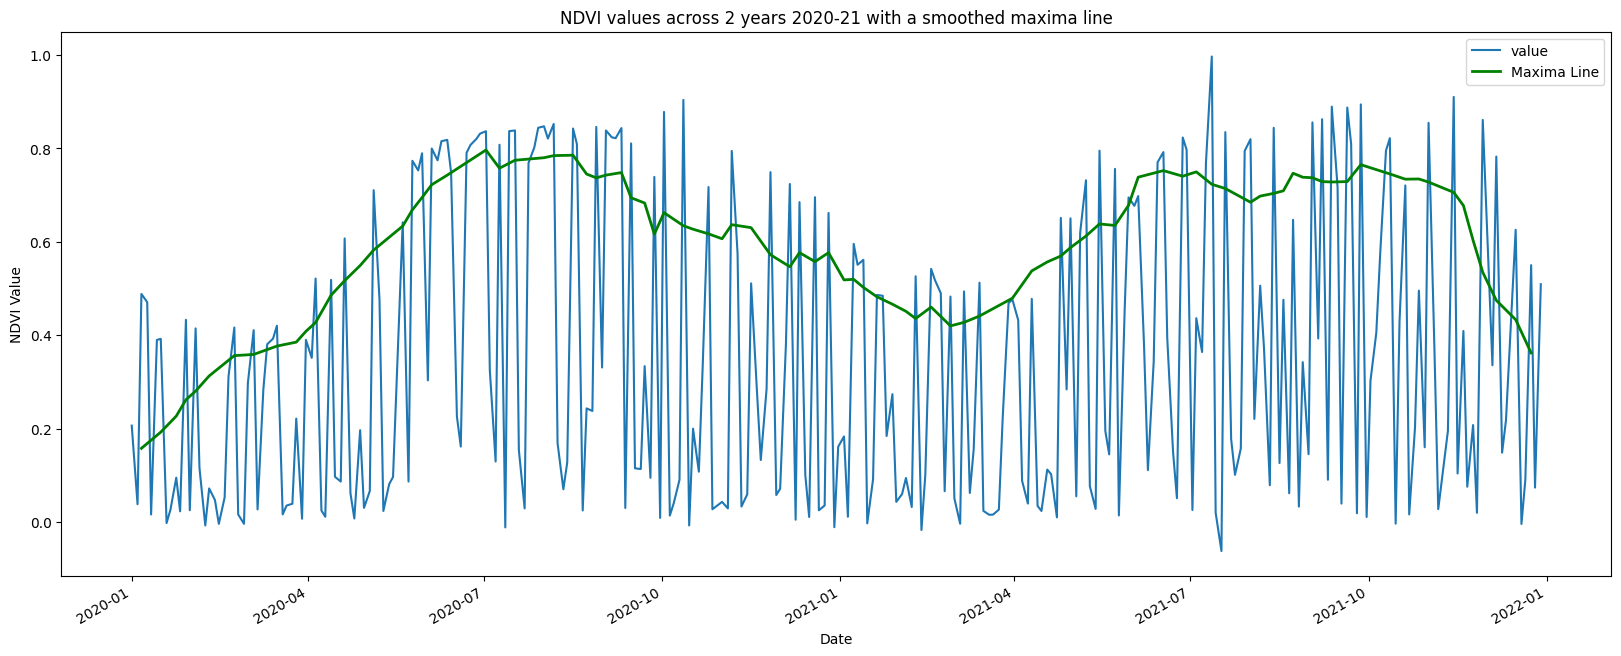

In [6]:
NDVI_title='NDVI values across 2 years 2020-21 with a smoothed maxima line'
point_df['value']=pd.to_numeric(point_df['value'], errors='coerce')
NDVI_data = pd.DataFrame(point_df[[ 'datetime','value']]).set_index('datetime')
plot_NDVI = NDVI_data.plot.line(title=NDVI_title, figsize=(20, 8))

max_indices = argrelextrema(point_df['value'].values, np.greater)[0]

# Connect maxima points with a line
plot_NDVI.plot(NDVI_data.iloc[max_indices].index, smooth(NDVI_data.iloc[max_indices]['value'],12), '-', color='green', alpha=1,linewidth=2, label='Maxima Line')

# Customize plot
plot_NDVI.set_xlabel('Date')
plot_NDVI.set_ylabel('NDVI Value')
plot_NDVI.legend()

# Show plot
plt.show()

In very few lines of code - we already have a time series plot!
It's interesting to observe a sine wave pattern which is likely due to the seasonal variation in vegetation activity like harvest and re-growth. NDVI values tend to oscillate over the course of a year due to changes in vegetation growth driven by factors like temperature, precipitation, and sunlight.

The noise data points that form the bottom most points in the wave are due to presence of clouds at the time of capturing the satellite images due to which the calculated NDVI values for those dates deviate from the expected normal.Refer to [this](cloudy_NDVI_raster_image.png) image to see an instance of a hazily calculated NDVI layer of the farmland due to presence of clouds.

#### Raster Query

Next, let's define and submit a raster query to AGB Geospatial APIs covering a square area in the same farmland for a specific date in 2023 and analyze the result.

In [7]:
NDVIResult = query.submit_check_status_and_download(
    {
              "publish": True,
              "name": "NDVI",
              "spatial": {
                "type": "square",
                 "coordinates": [
                  -38.30946,142.12825, -38.26109,142.19994
                ]
              },
              "temporal": {
                "intervals": [
                  {
                    "start": "2020-01-06 00:00:00",
                    "end": "2020-01-06 23:00:00"
                  }
                ]
              },
              "layers": [
                {
                  "type": "raster",
                  "id": "49464",
                  "output": True
                }
              ]
    }, client=EI_client_v3)

2024-11-06 08:38:00 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-11-06 08:38:01 - paw - INFO - The query was successfully submitted with the id: 1730851200_11281378.
2024-11-06 08:38:02 - paw - INFO - The query 1730851200_11281378 has the status Queued.
2024-11-06 08:38:34 - paw - INFO - The query 1730851200_11281378 has the status Succeeded.
2024-11-06 08:38:34 - paw - INFO - The query 1730851200_11281378 was successful after checking the status.
2024-11-06 08:39:05 - paw - INFO - The query 1730851200_11281378 has the status Succeeded.
2024-11-06 08:39:05 - paw - INFO - The query 1730851200_11281378 was successful after checking the status.
2024-11-06 08:39:05 - paw - INFO - The query download folder is set to the path /Users/environmental-intelligence/Environmental-Intelligence/geospatial_analytics/v3_apis/samples/industry_use_cases/agriculture_ndvi/download/.
2024-11-06 08:39:15 - paw - INFO - The query 1730851200_11281378 is a zip.
2024-11-06 08:39:15 - paw 

#### Utility funtions to display the tiff files

The query takes a few seconds to complete and downloads the output as a zip file in the /download folder within the same location as this notebook.Now let's display the resultant tiff and it's summary file using the following functions.

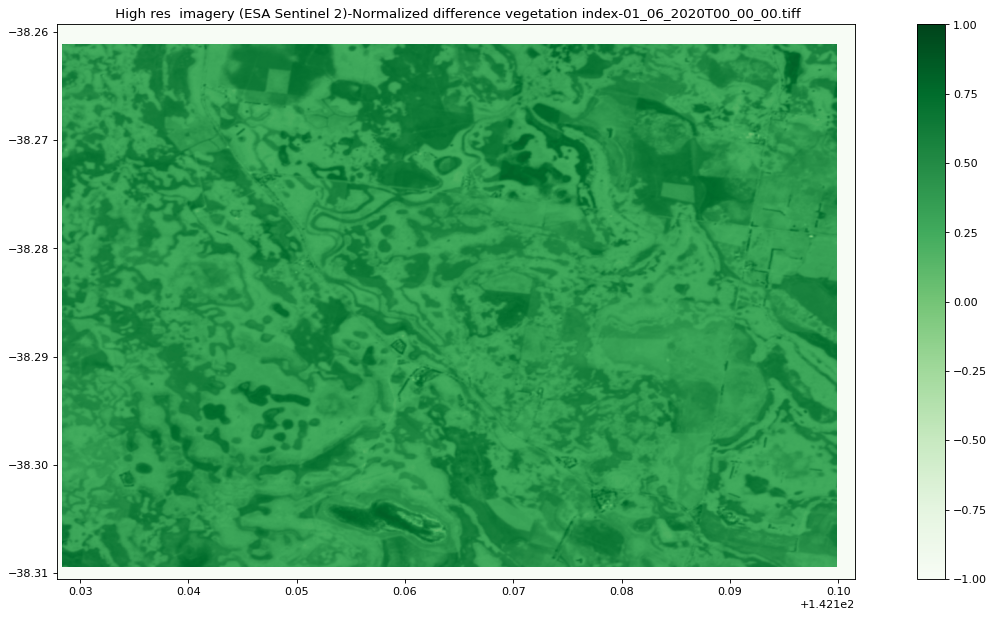

In [8]:
# Function to display the resulting Tiff(s).
NDVIResult_File_List = NDVIResult.list_files()
for file in NDVIResult_File_List:
    if file.endswith('.tiff'): #display the raster images
        with open(file+'.json', 'r') as summary_file:
            fileparms = json.load(summary_file)
        boundingBox=fileparms["boundingBox"]
        myextent=[boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]  
        arrayNDMI = np.array(PIL.Image.open(file))
        plt.figure(figsize = (20, 9), dpi=80) # Sets the size and resolution of the plot
        plt.imshow(arrayNDMI,cmap = 'Greens', vmin=-1, vmax=1,extent = myextent) # Loads the raster data and sets the colormap
        plt.colorbar() # Adds the color bar
        plt.title(" "+os.path.basename(file))               

In [9]:
# Function to display the resulting summary file(s).
for file in NDVIResult_File_List:
    if file.endswith('.json'):  #  show the result statistics
        summary=pd.read_json(file)
        summary['rasterStatistics'] = pd.to_numeric(summary['rasterStatistics'])
        pd.set_option('display.float_format', '{:.6f}'.format)
        display_summary(summary) 

,pixelType,pixelNoDataVal,spatialRef,boundingBox,pixelDimensions,rasterStatistics
minLatitude,fl,-9999,EPSG:4326,-38.310528,NaN,NaN
maxLatitude,fl,-9999,EPSG:4326,-38.259328,NaN,NaN
minLongitude,fl,-9999,EPSG:4326,142.127872,NaN,NaN
maxLongitude,fl,-9999,EPSG:4326,142.201600,NaN,NaN
pixelSizeDegreeLongitude,fl,-9999,EPSG:4326,NaN,0.000064,NaN
pixelSizeDegreeLatitude,fl,-9999,EPSG:4326,NaN,0.000064,NaN
numberPixelsLatitude,fl,-9999,EPSG:4326,NaN,800.000000,NaN
numberPixelsLongitude,fl,-9999,EPSG:4326,NaN,1152.000000,NaN
pixelMin,fl,-9999,EPSG:4326,NaN,NaN,-0.081200
pixelMax,fl,-9999,EPSG:4326,NaN,NaN,0.826900


## Understanding the output:

The output is displayed in two forms: 
 
- The first one is the raster tiff file plotted on the coordinate system.The colormap used in the range of [-1,1] helps visualize how green/barren the area is.Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation.

- The second one is a table that gives varied pixel information.`pixelType` tells us that the pixel values are of float type , `pixelNoDataVal` suggests that any pixel with no data would have the value of -9999. EPSG:4326 `spatialRef`refers to the EPSG code for the WGS84 coordinate system, which stands for World Geodetic System 1984 which is a standard coordinate reference system used by the Global Positioning System (GPS) and widely adopted for geographic data.`boundingBox` specifies the square boundary queried for in the form of minLatitude,maxLatitude,minLongitude and maxLongitude.`pixelDimensions` gives information on the number of pixels along the latitude and longitude along with an indication of the amount of geographic area covered by each pixel of the raster data along the latitude and longitude.`rasterStatistics` tells us the minimum,maximum,mean,standard deviation pixel values of all pixels in the tiff along with the total count of pixels.

### NDVI applications
- NDVI can be captured at different stages of areas of vegetation by querying across different time periods.Patterns in NDVI can reveal differences in growth rates, identify areas of poor crop performance, and guide decisions on irrigation, fertilization, and pest management.

- NDVI is sensitive to various stress factors affecting plants, including water stress (drought), nutrient deficiencies, diseases, and pest damage. By regularly monitoring NDVI, farmers can detect these stress factors early and take corrective actions.

- Beyond agriculture, NDVI time series are used in environmental monitoring and assessment. They provide insights into changes in land cover, vegetation regeneration after disturbances (e.g., wildfires, deforestation), and the impact of climate change on ecosystems.

- Governments, conservation organizations, and land managers use NDVI time series to support land management decisions, such as prioritizing areas for conservation, monitoring reforestation efforts, and assessing the effectiveness of land restoration projects.

## Displaying the tiff files on the map

Below is the code snippet to overlay the tiff on a world map to get an interactive visual display, after which we display the screenshot of the same for ease of rendering the notebook.

In [ ]:
min_lon, max_lon = 142.12049, 142.20271
min_lat, max_lat = -38.31387, -38.25878
Map = folium.Map( max_bounds=True,
                    location=[48.7080,-104.5045],
                    zoom_start=13,
                    min_lat=min_lat,
                    max_lat=max_lat,
                    min_lon=min_lon,
                    max_lon=max_lon )


for NDVI_result_file in NDVIResult_File_List:    
    if NDVI_result_file.endswith('.tiff'):
        with rasterio.open(NDVI_result_file) as raster_file:
            jpg_img_filename=NDVI_result_file.replace(".tiff",".jpg")
            png_img_filename=NDVI_result_file.replace(".tiff",".png")
            data = raster_file.read(1)
            data[data==-9999] = np.nan
            data[data==0] = np.nan

            cmap = plt.get_cmap('Greens')
            new_cmap_colors = cmap(np.linspace(0.2, 1, cmap.N))
            new_cmap = mcolors.LinearSegmentedColormap.from_list('DarkTerrain', new_cmap_colors)
            colored_data = (new_cmap(data) * 255).astype(np.uint8)
            plt.savefig(jpg_img_filename, bbox_inches='tight', pad_inches=0)            
            im = Image.fromarray(colored_data)
            im.save(jpg_img_filename, "PNG")

            folium.raster_layers.ImageOverlay(
                        image=jpg_img_filename,opacity=0.8,
                        bounds=[[min_lat, min_lon], [max_lat, max_lon]]
                    ).add_to(Map)
            Map.add_child(cm.linear.Greens_09.scale(-1, 1))
Map

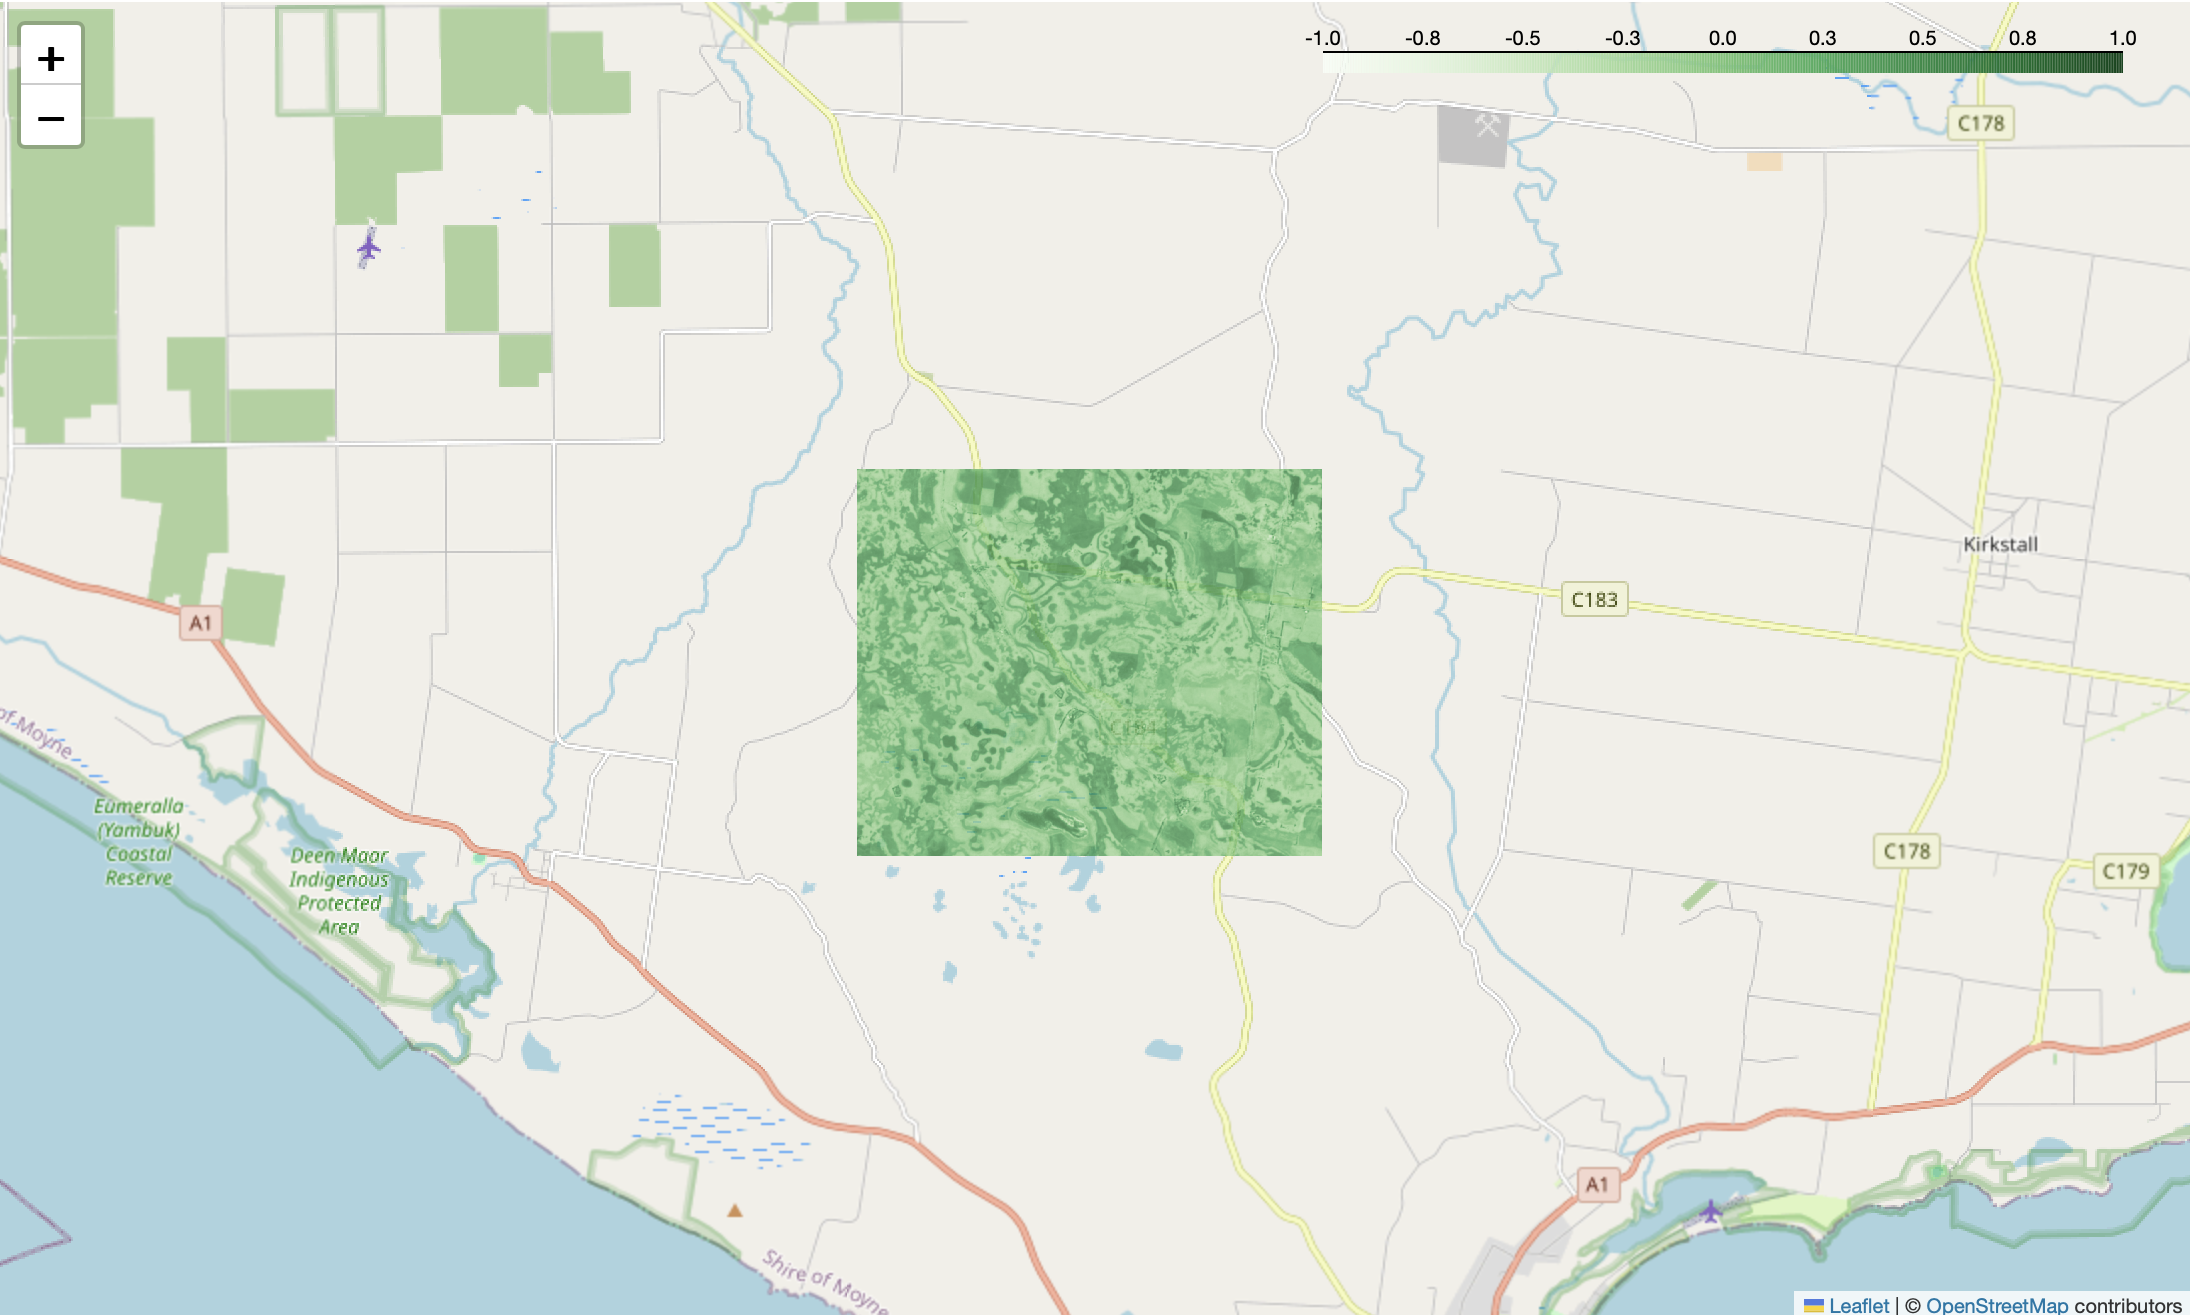

In [11]:
display.Image('NDVI_raster_image_on_map.png')